# E-08 카메라 스티커앱 만들기 

<br> 

#### 목표 

|평가문항|상세기준|
|:---|:---|
|1.자기만의 카메라앱 기능 구현을 완수하였다. |원본에 스티커 사진이 정상적으로 합성되었다.|
|2. 스티커 이미지를 정확한 원본 위치에 반영하였다.|정확한 좌표계산을 통해 고양이 수염의 위치가 원본 얼굴에 잘 어울리게 출력되었다.|
|3. 카메라 스티커앱을 다양한 원본이미지에 적용했을 때의 문제점을 체계적으로 분석하였다.|얼굴각도, 이미지 밝기, 촬영거리 등 다양한 변수에 따른 영향도를 보고서에 체계적으로 분석하였다.|

<br>

### (1) 라이브러리 import 


In [1]:
import os
import cv2
import matplotlib.pyplot as plt
import numpy as np
import dlib

### (2) 사진 불러오기 및  얼굴 검출  

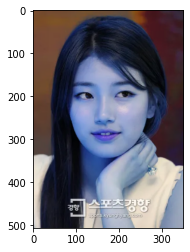

In [2]:
my_image_path = os.getenv('HOME')+'/aiffel/camera_sticker/images/suzi.png'
img_bgr = cv2.imread(my_image_path)    # OpenCV로 이미지를 불러옵니다
img_show = img_bgr.copy()      # 출력용 이미지를 따로 보관합니다
plt.imshow(img_bgr)
plt.show()

- openCV 는 BGR 로 표현되어 RGB 채널로 변경 및 얼굴 detection 작업을 진행

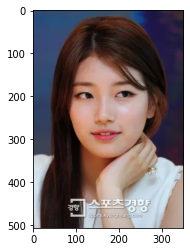

In [3]:
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
plt.imshow(img_rgb)
plt.show()

In [4]:
# detector를 선언합니다
detector_hog = dlib.get_frontal_face_detector()
detector_hog

In [5]:
#이미지 upsampling 방법으로 크기를 키우는 것을 이미지 피라미드
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
dlib_rects = detector_hog(img_rgb, 1)   # (image, num of image pyramid)
dlib_rects #rectangle[[시작지점,종료지점]]

rectangles[[(77, 160) (262, 345)]]

rectangles[[(77, 160) (262, 345)]]


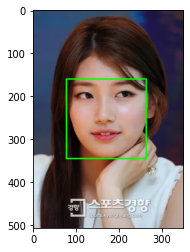

In [6]:
# 찾은 얼굴 영역 박스 리스트
# 여러 얼굴이 있을 수 있습니다
print(dlib_rects)   

for dlib_rect in dlib_rects:
    l = dlib_rect.left()
    t = dlib_rect.top()
    r = dlib_rect.right()
    b = dlib_rect.bottom()

    cv2.rectangle(img_show, (l,t), (r,b), (0,255,0), 2, lineType=cv2.LINE_AA)

img_show_rgb =  cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

### (3) 얼굴 인식 후 랜드마크 추출

In [7]:
model_path = os.getenv('HOME')+'/aiffel/camera_sticker/models/shape_predictor_68_face_landmarks.dat'
landmark_predictor = dlib.shape_predictor(model_path)

In [8]:
list_landmarks = []

# 얼굴 영역 박스 마다 face landmark를 찾아냅니다
for dlib_rect in dlib_rects:
    points = landmark_predictor(img_rgb, dlib_rect)
    # face landmark 좌표를 저장해둡니다
    list_points = list(map(lambda p: (p.x, p.y), points.parts()))
    list_landmarks.append(list_points)

print(len(list_landmarks[0]))

68


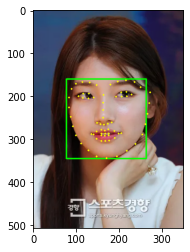

In [9]:
for landmark in list_landmarks:
    for point in landmark:
        cv2.circle(img_show, point, 2, (0, 255, 255), -1)

img_show_rgb = cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

### (3) 고양이 스티커 적용하기 

- Landmark를 활용해서 sticker_area 구하기
- 수염을 붙이기 위해서 코의 index 30을  활용 
- w, h => 얼굴을 인식한 전체 사각형 (size = 155:155)

In [10]:
for dlib_rect, landmark in zip(dlib_rects, list_landmarks):
    x = landmark[2][0]
    y = landmark[36][1]
    w = (landmark[30][0] - x)*2 
    h = landmark[48][1] - y
    print(dlib_rect)
    print ('(x,y) : (%d,%d)'%(x,y))
    print ('(w,h) : (%d,%d)'%(w,h))

[(77, 160) (262, 345)]
(x,y) : (87,200)
(w,h) : (150,88)


- 수염 이미지의 크기를 사각형의 크기와 동일하게 ```resize```를 해준다.
- 수염 이미지를 뿌려줄 **좌측 상단**의 값 (```refined_x```, ```refined_y```) 설정
    - ```y<0``` = 사진 영역 위로 나가는 경우
    - ```x<0``` = 시잔 영역 왼쪽으로 나가는 경우

In [11]:
#고양이 스티커 불러오기
cat_path = os.getenv('HOME')+'/aiffel/camera_sticker/images/cat-whiskers.png' 
cat_sticker = cv2.imread(cat_path)
cat_sticker = cv2.resize(cat_sticker, (w,h))
print (cat_sticker.shape)

(88, 150, 3)


In [12]:
cat_area = img_show[y:y+cat_sticker.shape[0],x:x+cat_sticker.shape[1]]
img_show[y:y+cat_sticker.shape[0],x:x+cat_sticker.shape[1]] = \
    np.where(cat_sticker==255,cat_area,cat_sticker).astype(np.uint8)


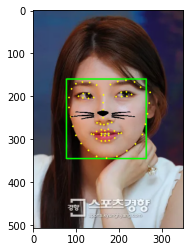

In [13]:
plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()


In [14]:
refined_x = x - w // 2
refined_y = y - h
print ('(x,y) : (%d,%d)'%(refined_x, refined_y))

(x,y) : (12,112)


In [15]:
if refined_x < 0: 
    cat_sticker = cat_sticker[:, -refined_x:]
    refined_x = 0
if refined_y < 0:
    cat_sticker = cat_sticker[-refined_y:, :]
    refined_y = 0

print ('(x,y) : (%d,%d)'%(refined_x, refined_y))

(x,y) : (12,112)


### (4) Bounding box 와 Landmark 제거 해주기 

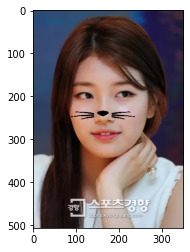

In [16]:
#img_show 대신 img_bgr 사용하기 

cat_area = img_bgr[y:y+cat_sticker.shape[0],x:x+cat_sticker.shape[1]]
img_bgr[y:y+cat_sticker.shape[0],x:x+cat_sticker.shape[1]] = \
    np.where(cat_sticker==255,cat_area,cat_sticker).astype(np.uint8)

plt.imshow(cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB))
plt.show()

- 어여쁜 수지 코에 수염 붙이기 성공! 

### (5) 다양한 변수에 따른 영향도 분석

In [17]:
# 이미지들의 경로 저장
image_paths =[]
image_paths.append(os.getenv('HOME')+'/aiffel/camera_sticker/images/image3.jpg')
image_paths.append(os.getenv('HOME')+'/aiffel/camera_sticker/images/image.jpg')
image_paths.append(os.getenv('HOME')+'/aiffel/camera_sticker/images/side.jpg')
image_paths.append(os.getenv('HOME')+'/aiffel/camera_sticker/images/uptodown.jpg')

### (6) 이미지 읽기 함수 : ```load_image```

- 입력인자
    - list형식으로 이미지들의 경로를 입력
- 출력
    - 사진들을 rgb채널의 ndarray로 열고 리스트에 담아서 반환

In [18]:
def load_image(paths):
    img_lst = []
    
    # 입력받은 경로가 list일 경우, for문을 돌면서 list에 이미지를 담는다.
    if str(type(paths)) == "<class 'list'>" :
        for path in paths:
            img_bgr = cv2.imread(path)
            h, w, _ = img_bgr.shape
            if h-w < 0 :
                img_bgr = cv2.resize(img_bgr, (640, 480))
            else :
                img_bgr = cv2.resize(img_bgr, (480, 640))

            img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
            img_lst.append(img_rgb)
    
    # 하나의 경로로 이미지를 읽어 들이고 list에 담는다
    else : 
        img_bgr = cv2.imread(paths)
        h, w, _ = img_bgr.shape
        if h-w < 0 :
            img_bgr = cv2.resize(img_bgr, (640, 480))
        else :
            img_bgr = cv2.resize(img_bgr, (480, 640))

        img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
        img_lst.append(img_rgb)
    
    return img_lst

In [19]:
# 이후에 사용될 사진들을 미리 img_lst에 담아 둔다.
img_lst = load_image(image_paths)

### (7) 얼굴인식 함수 : ```face_detection```
- 입력인자
    - ```img_rgb``` : ndarray형태의 image를 입력으로 받음
    - ```inner```
        - ```True``` : 입력받은 image로부터 얼굴은 인식한 결과물 (```dlib_rects```, ```list_landmarks```)를 반환
        - ```False(default)``` : 반환하는 값은 따로 없고, 사진에 대한 detection결과만 사진으로 출력
- 출력인자
    - 사진 결과물 출력 및 얼굴인식 Bounding Box, landmark좌표

In [20]:
def face_detection(img_rgb, inner=False):
    img_show = img_rgb.copy()

    # 얼굴 인식
    dlib_rects = detector_hog(img_rgb, 3)

    if dlib_rects :
        print("얼굴 인식 성공")
           
        for dlib_rect in dlib_rects:
            l = dlib_rect.left()
            t = dlib_rect.top()
            r = dlib_rect.right()
            b = dlib_rect.bottom()

            cv2.rectangle(img_show, (l,t), (r,b), (0,255,0), 2, lineType=cv2.LINE_AA)
            
        if not inner :
#             print(dlib_rects) # 찾은 얼굴영역 좌표
            plt.imshow(img_show)
            plt.show()
            print("marking landmark...")
        
        list_landmarks = []
        for dlib_rect in dlib_rects:
            points = landmark_predictor(img_rgb, dlib_rect)
            list_points = list(map(lambda p: (p.x, p.y), points.parts()))
            list_landmarks.append(list_points)

        for landmark in list_landmarks:
            for idx, point in enumerate(list_points):
                cv2.circle(img_show, point, 2, (0, 255, 255), -1) # yellow
        
        if not inner :
            plt.imshow(img_show)
            plt.show()
            print("-"*30+'\n')
    else :
        print("얼굴 인식 실패")
        return False
    
    if inner:
        return dlib_rects, list_landmarks


### (8) 얼굴 각도 조정 함수 : ```rotate_image```
- 입력인자
    - ```image``` : ndarray형식의 image
    - ```angle``` : 회전을 원하는 각도(ex. 10, 20, 30 ...) 
        - ```angle``` > 0 : 시계 방향
        - ```angle``` < 0 : 반시계 방향
    - ```save```
        - True : 노트북 파일과 동일 위치에 rotate.jpg이미지를 저장.
- 결과물
    - 회전을 한 ndarray형태의 이미지 및 저장되는 image

In [21]:
def rotate_image(image, angle, save=False) :
    image_center = tuple(np.array(image.shape[1::-1]) / 2)
    rot_mat = cv2.getRotationMatrix2D(image_center, -angle, 1.0)
    result = cv2.warpAffine(image, rot_mat, image.shape[1::-1], flags=cv2.INTER_LINEAR)
    if save :
        print('저장경로 : ./rotate.jpg')
        cv2.imwrite('rotate.jpg', result)
    return result

저장경로 : ./rotate.jpg


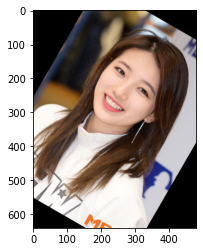

In [22]:
# 30도 rotation확인, save=True
img_lst = load_image(image_paths)
plt.imshow(rotate_image(img_lst[0], 30, save=True))

얼굴 인식 성공


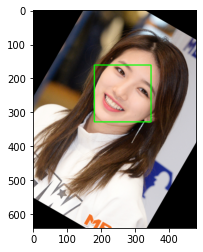

marking landmark...


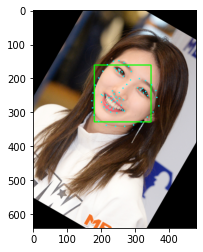

------------------------------



In [23]:
# rotation + face_detection
face_detection(rotate_image(img_lst[0], 30), inner=False)

In [24]:
face_detection(rotate_image(img_lst[0], 90), inner=False)

얼굴 인식 실패


False

얼굴 인식 성공


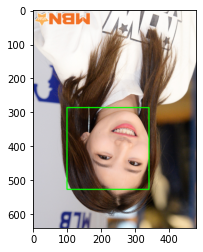

marking landmark...


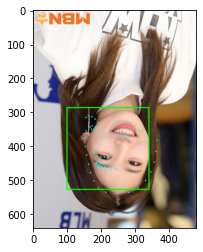

------------------------------



In [25]:
face_detection(rotate_image(img_lst[0], 180), inner=False)

얼굴 인식 성공


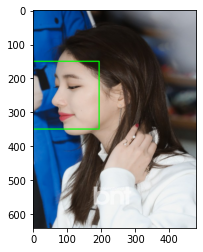

marking landmark...


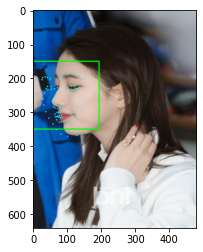

------------------------------

얼굴 인식 성공


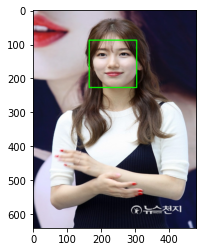

marking landmark...


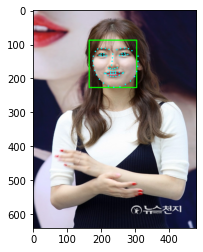

------------------------------



In [26]:
for img in img_lst[2:4] :
    face_detection(img)

### (9) 이미지 밝기 조절 함수 : ```mod_brightness```
- 입력인자
    - ```img``` : ndarray형식의 image
    - ```brightness```
        - ```True(Default)``` : 이미지를 밝게 조절
        - ```False``` : 이미지를 어둡게 조절
- 출력
    - 밝기를 수정한 ndarray형태의 image를 반환

In [27]:
def mod_brightness(img, brightness=True):
    
    if brightness :
        m = np.ones(img.shape, dtype="uint8") * 100
        result = cv2.add(img, m)
    else :
        m = np.ones(img.shape, dtype="uint8") * 50
        result = cv2.subtract(img, m)
        
    return result

얼굴 인식 성공


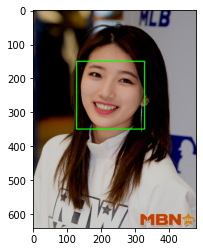

marking landmark...


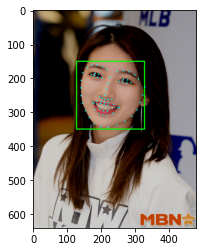

------------------------------



In [28]:
# 어둠게 + face_detection
for img in img_lst[:1]:
    dark_img = mod_brightness(img, brightness=False)
    face_detection(dark_img)

얼굴 인식 성공


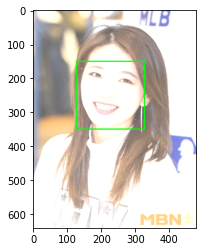

marking landmark...


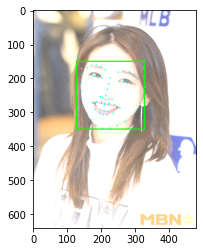

------------------------------



In [29]:
# 밝게 + face_detection
for img in img_lst[:1]:
    bright_img = mod_brightness(img, brightness=True)
    face_detection(bright_img)

### (10) 촬영거리 조절 함수 : ```paddedzoom```
- 이미지를 축소할 경우에 가장자리를 0으로 Padding 해준다.
- 입력인자
    - ```img``` : ndarray형식의 image
    - ```zoom```
        - ```0<zoom<1``` : 축소
        - ```zoom=1``` : 그대로 출력
        - ```zoom>1``` : 확대

In [30]:
def paddedzoom(img, zoom) :
    out = np.zeros(img.shape)
    zoomed = cv2.resize(img, dsize=(0,0), fx = zoom, fy = zoom)
    
    h, w, _ = img.shape
    zh, zw, _ = zoomed.shape
    
    if zoom<1 :
        out[(h-zh)//2:-(h-zh)//2, (w-zw)//2:-(w-zw)//2] = zoomed
    elif zoom > 1:
        out = zoomed[(zh-h)//2 : -(zh-h)//2, (zw-w)//2:-(zw-w)//2]
    else :
        out = img
        
    return out.astype(np.uint8)

In [31]:
def paddedzoom(img, zoom) :
    out = np.zeros(img.shape)
    zoomed = cv2.resize(img, dsize=(0,0), fx = zoom, fy = zoom)
    
    h, w, _ = img.shape
    zh, zw, _ = zoomed.shape
    
    if zoom<1 :
        out[(h-zh)//2:-(h-zh)//2, (w-zw)//2:-(w-zw)//2] = zoomed
    elif zoom > 1:
        out = zoomed[(zh-h)//2 : -(zh-h)//2, (zw-w)//2:-(zw-w)//2]
    else :
        out = img
        
    return out.astype(np.uint8)

얼굴 인식 성공


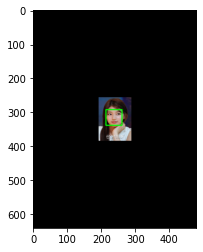

marking landmark...


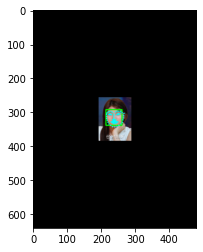

------------------------------



In [32]:
# zoom rate = 0.2
face_detection(paddedzoom(img_lst[1], 0.2))

얼굴 인식 성공


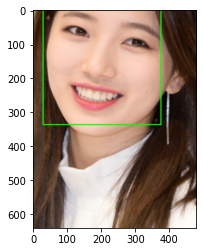

marking landmark...


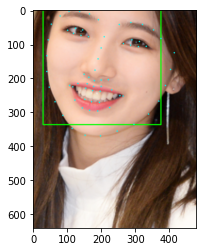

------------------------------



In [33]:
# zoom rate = 2
face_detection(paddedzoom(img_lst[0], 2))

얼굴 인식 성공


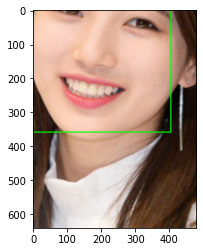

marking landmark...


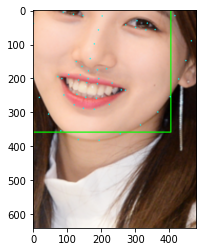

------------------------------



In [34]:
# zoom rate = 3
face_detection(paddedzoom(img_lst[0], 2.5))

# 회고 


<br> 

- 이번 노드는 CV 와 NLP 중 어떤쪽을 선택하나 하는 개인적인 고민을 어느정도 해결해 주는 기회가 됐던것 같다. 사진을 불러와 얼굴인식 후 랜드마크 추출을 하는 일련의 과정이 꽤 재미있었고 (아름다운수지)셀카에 고양이 수염 스티커는 예쁘게 잘 붙일 수 있었다. 



- 수염을 붙여본 후 다양한 시도를 해 보았고 잘되는 부분도 있고 안되는 부분도 있었는데 실행속도는 특별히 문제는 없었던 것 같다. 결과를 다음과 같이 정리할 수 있다:  


- 얼굴의 각도변경 / 회전 
    - 30도에서는 얼굴을 인식하긴 했지만 랜드마크 정확도가 떨어진다. 
    - 90도에서는 인식을 아예 못하였다. 
    - 180도 회전은 얼굴을 인식하여 bounding box는 잘 찾았지만 랜드마크는 정확도는 많이 떨어진다. 
    - 옆모습 사진은 아예 얼굴을 벗어나 랜드마크가 찍혀 상당히 부정확 하다는 것을 알 수 있다. 앞모습은 매번 거의 정확하다. 
    - 그에 대한 정확한 이유와 성능개선을 위해서는 앞으로 다른 노드와 풀립수업을 통해서 배울 수 있을거라 기대한다. 
            
                     
- 밝기 조절
 
    - dlib의 face detector는 HOG(Histogram of Oriented Gradients)와 SVM(Support Vector Machine)을 사용해서 얼굴을 찾는데 밝기 조절은 예상대로 얼굴에 잘 맞게 bounding box 적용이 되었고 눈 코 입 턱을 잘 맞춰 랜드마크 추출이 되었다
          
        
- 촬영거리
     - 촬영 거리는 이미지를 확대하고 축소를 해줌으로 써 조절을 해주었다.
     - 거리 조절은 bounding box 적용과 랜드마크 추출에 기본적으로 크게 영향을 주지는 않아 비교적 잘 인식을 했고 랜드마크 추출이 되긴했지만, 사진이 너무 작아지는 경우, 눈 코 입 턱 구분이 힘들어 정확한 스티커 부착이 어려워 질 것이다. 